In [102]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn.impute import SimpleImputer, KNNImputer
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from lussi.stackoverflow import *
from lussi.ziprecruiter import *
nogit_data_dir = "622data_nogit"
wide_stack = load_stack(data_dir = nogit_data_dir, stack_type=StackType.WIDE)
pd.set_option('display.max_columns', None)
print(f"Length of wide_stack is: {len(wide_stack)}") 

Length of wide_stack is: 549482


In [98]:
# What does the data look like?
from itables import show
show(wide_stack.sample(n=10, random_state=42), scrollY='300px', paging=True)

In [113]:
df = wide_stack

# Step 1: Split 'DevType' column into multiple roles
devtype_series = df['DevType'].str.split(';').explode()

# Step 2: Count the frequency of each role
role_counts = devtype_series.value_counts()

# Step 3: Display the top 20 most common roles (optional)
print(role_counts.head(20))

DevType
Developer, full-stack                            156674
Developer, back-end                              137304
Developer, front-end                              84162
Developer, desktop or enterprise applications     53586
Back-end developer                                53300
Full-stack developer                              44353
Developer, mobile                                 44211
Database administrator                            39444
Student                                           39431
DevOps specialist                                 39227
System administrator                              36276
Designer                                          35178
Front-end developer                               34822
Data scientist or machine learning specialist     26821
Web developer                                     26235
Data or business analyst                          25707
Developer, embedded applications or devices       22364
Engineering manager                     

In [89]:
# Group and calculate the percentage of non-null values for the filtered columns
grouped_summary_filtered = wide_stack.groupby("Year").agg(lambda x: (x.notnull().mean() * 100)).reset_index()
# Round the result to one decimal place
grouped_summary_filtered_rounded = grouped_summary_filtered.round(1)
# Display the grouped summary
# from IPython.display import display
# display(grouped_summary_filtered_rounded)
show(grouped_summary_filtered_rounded, scrollY='300px', paging=True)

# ok lots to get rid of. 

What kind of models should we use?

XGBoost is our first choice for predicting salary.

* Robust to missing values: XGBoost can handle NaNs natively, reducing the need for manual imputation.
* Scalable to large datasets: It’s optimized for both speed and performance.
* Can apture nonlinear relationships between features.
* Supports feature importance analysis: Easy to extract and interpret feature importance.
* Cross-year generalization: XGBoost can generalize well across years by capturing complex trends.

Another choice would be Ramdom Forest, but it may overfit, will require imputation, and is most likely going to lag behind XGBoost. We'll do them both. 




In [114]:
def group_gender(gender):
    gender = str(gender).lower()  # Converts to lowercase
    if 'female' in gender or 'woman' in gender:
        return 'Female'
    elif 'male' in gender or 'man' in gender:
        return 'Male'
    else:
        return 'Other'
        
def parse_devtype(df):
    devtype_dummies = df['DevType'].str.get_dummies(sep=';')  # One-hot encode DevType roles
    return pd.concat([df, devtype_dummies], axis=1)  # Add the encoded roles to the DataFrame
    
# Step 2: Apply transformations, including parsing and encoding 'DevType'
filtered_stack = (
    wide_stack
    .query("Year != 2019 and Year != 2020")  # No salary
    .query("Year != 2017")  # No age
    .query("Country == 'United States'")  # Forget that!
    .assign(gender_grouped=wide_stack['Gender'].apply(group_gender))  # Add gender_grouped, simplify to m/f/o
    .pipe(parse_devtype)  # Add in DevType columns
    .drop('Gender', axis=1) 
    .drop('Sexuality', axis=1)  # DE: sexuality_grouped as either straight or lgbtq+
    .drop('Ethnicity', axis=1)  # DE: ethnicity_grouped, either minority or non-minority
    .drop('PlatformWorkedWith', axis=1)  # DE: expanded in calculated columns
    .drop('LanguageWorkedWith', axis=1)  # DE: expanded in calculated columns
    .drop('DatabaseWorkedWith', axis=1)  # DE: expanded in calculated columns
    .drop('US_State', axis=1)  # Too few
    .drop('Country', axis=1) 
    .drop('YearsCodePro', axis=1)  # DE: Replaced by YearsCodeProAvg
    .drop('OrgSize', axis=1)  # DE: Handled by OrgSizeAvg
    .drop('Age', axis=1)  # DE: Replaced with average age
    .drop('DevType', axis=1)  # Already expanded into one-hot columns
    .query('AnnualSalary > 1')   
)


print(f"Length of filtered_stack is: {len(filtered_stack)}") 
# filtered_columns = wide_stack
# Group and calculate the percentage of non-null values for the filtered columns
grouped_summary_filtered = filtered_stack.groupby("Year").agg(lambda x: (x.notnull().mean() * 100)).reset_index()
# Round the result to one decimal place
grouped_summary_filtered_rounded = grouped_summary_filtered.round(1)
# Display the grouped summary
show(grouped_summary_filtered_rounded, scrollY='300px', paging=True)
show(filtered_stack.sample(n=10, random_state=42), scrollY='300px', paging=True)

Length of filtered_stack is: 43204


Mean Absolute Error (MAE): 235913.70
Mean Squared Error (MSE): 723577656396.97
Root Mean Squared Error (RMSE): 850633.68
R² Score: -0.21685


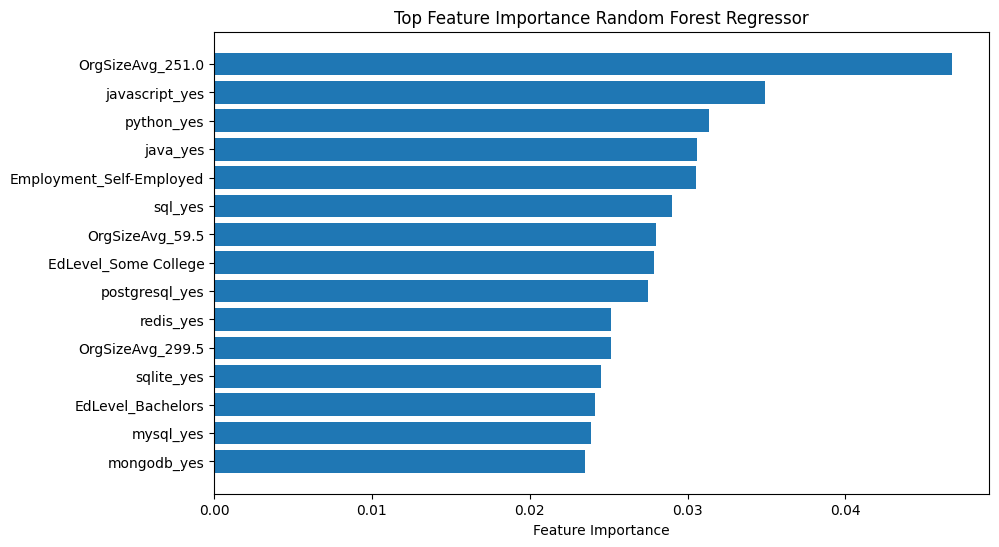

In [110]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Identify categorical columns and fill missing values if necessary
df = filtered_stack.fillna('Unknown')  # Handle missing values

# Step 2: Separate the target and features before encoding
y = df['AnnualSalary']  # Target variable
X = df.drop(['AnnualSalary', 'Year'], axis=1)  # Drop target and irrelevant columns

# Step 3: Apply one-hot encoding to features only
X_encoded = pd.get_dummies(X, drop_first=True)

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Step 5: Train the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 6: Make Predictions
y_pred = rf_model.predict(X_test)

# Step 7: Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R² Score

# Print Evaluation Metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.5f}")

# Step 8: Get feature importances from the trained model
importances = rf_model.feature_importances_

# Step 9: Get the feature names from the encoded DataFrame
feature_names = X_encoded.columns

# Step 10: Sort feature importances in descending order
indices = np.argsort(importances)[::-1]  # Sort in descending order

# Step 11: Select the top 15 most important features (optional)
top_n = 15
top_indices = indices[:top_n]

# Step 12: Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(
    [feature_names[i] for i in top_indices], 
    importances[top_indices], 
    align='center'
)
plt.xlabel('Feature Importance')
plt.title('Top Feature Importance Random Forest Regressor')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature on top
plt.show()

Mean Absolute Error (MAE): 216126.99
Mean Squared Error (MSE): 658689958998.30
Root Mean Squared Error (RMSE): 811597.17
R² Score: -0.10772


<Figure size 1000x600 with 0 Axes>

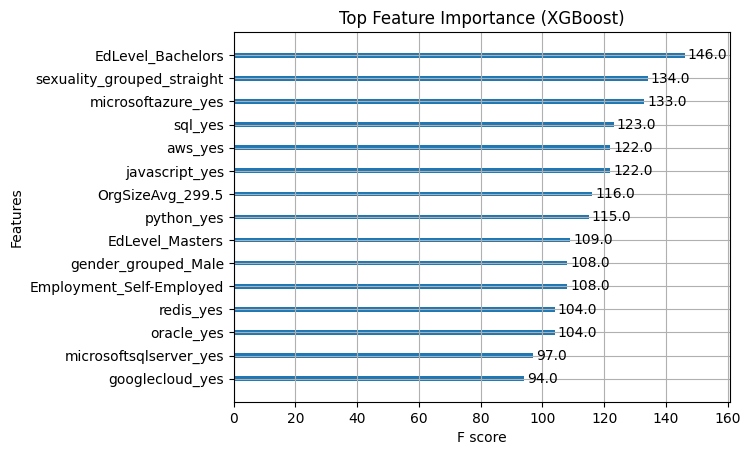

In [111]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Prepare the data
df = filtered_stack.fillna('Unknown')  # Handle missing values
y = df['AnnualSalary']  # Target variable
X = df.drop(['AnnualSalary', 'Year'], axis=1)  # Drop target and irrelevant columns

# Step 2: Apply one-hot encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Step 4: Train the XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Step 5: Make Predictions
y_pred = xgb_model.predict(X_test)

# Step 6: Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R² Score

# Print Evaluation Metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.5f}")

# Step 7: Plot Feature Importance using XGBoost's built-in plot function
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, max_num_features=15)  # Top 15 features
plt.title('Top Feature Importance (XGBoost)')
plt.show()

### Random Forest Regressor:
* Random Forest is known for being robust and interpretable, especially for datasets with many categorical features. The feature importance plot suggests it emphasizes technical skills and organizational details.
* Focuses heavily on organizational size and and technology-related features like javascript_yes and python_yes
* Education level (EdLevel_Some College, EdLevel_Bachelors) also plays a role but is not the top priority in this model.
* Seems to favor granular insights about job-related technologies and company sizes.
	
### XGBoost:
* XGBoost captures a broader variety of features, which makes it more likely to pick up complex interactions between variables (like how gender or cloud technologies relate to salary).
* Generally uses a more broad mix of features including including cloud-related tech, gender, self employemnt. 
* Higher weight given to educational level 
	



